<center> <h1>BCG - COVID-19 AI Challenge</h1> </center>
<center> <h3>Task 2: "BCG - COVID-19" - Find Insights that Could Help the Clinical Trials </h3> </center>

# NOTE:

* Due to lack of data from low income countries, in this analysis we consider data only from middle income and high income countries.
* We also restrict ourselves to countries which has reported more than 1000 covid cases. 


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from matplotlib.pyplot import plot

pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 100000000)

# Downloaded country income class from the below link:
# https://datatopics.worldbank.org/world-development-indicators/the-world-by-income-and-region.html

# Mapping the global use of different BCG vaccine strains
Source: Nicole Ritza, Nigel Curtis. Mapping the global use of different BCG vaccine strains
[http://blisty.cz/video/TB.pdf]
http://www.bcgatlas.org/index.php
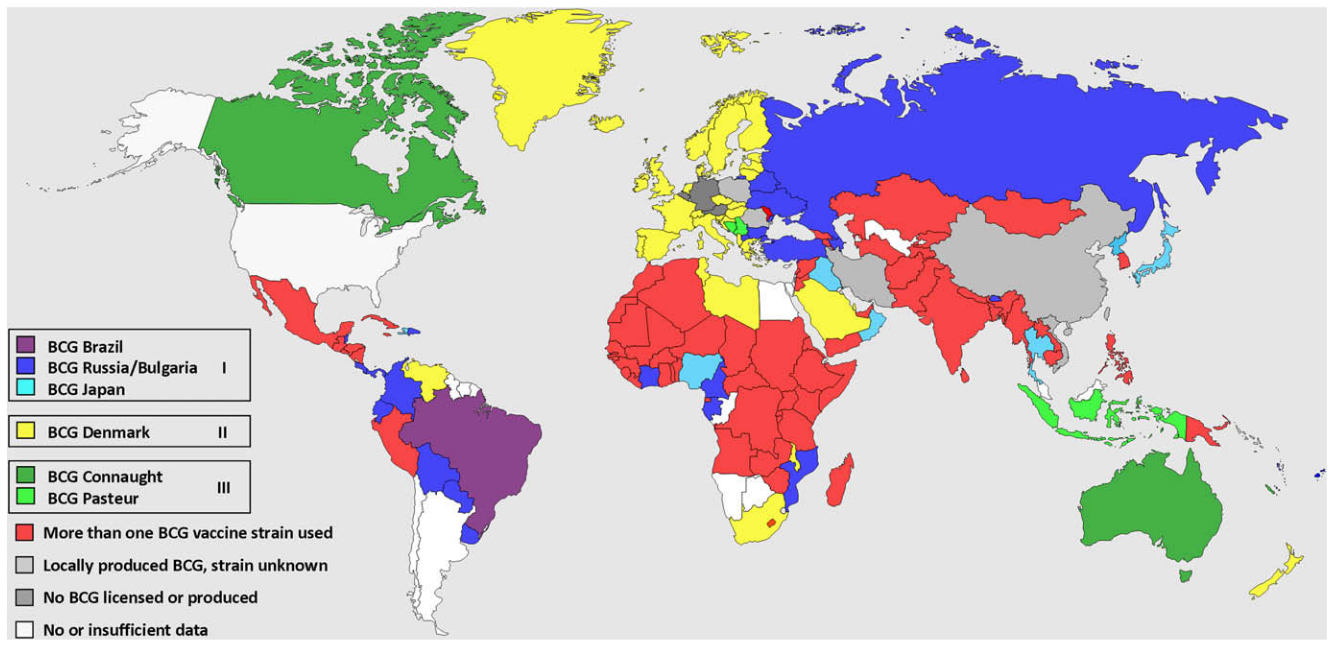

# Current BCG Vaccination status
Source: http://www.bcgatlas.org/index.php

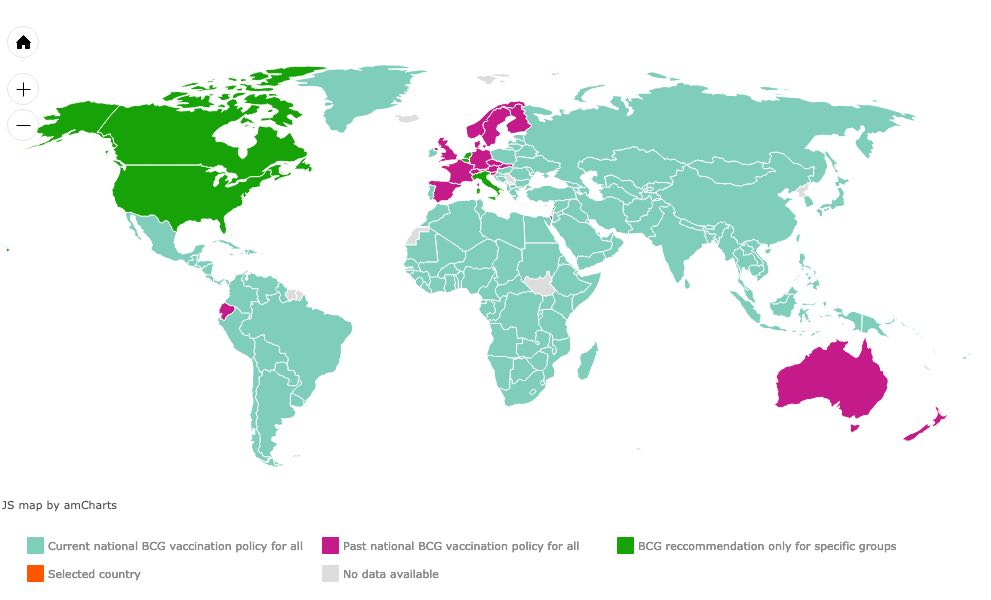


# Reading the CSV Files

In [ ]:
# CSV files which are a part of kaggle's competition data
t2_covid_death_first_df = pd.read_csv('/kaggle/input/hackathon/task_2-COVID-19-death_cases_per_country_after_frist_death-till_26_June.csv')
bcg_atlas_df = pd.read_csv('/kaggle/input/hackathon/BCG_world_atlas_data-2020.csv')
bcg_country_data_df = pd.read_csv('/kaggle/input/hackathon/BCG_country_data.csv')
t2_bcg_atlas_july7_df = pd.read_csv('/kaggle/input/hackathon/task_2-BCG_world_atlas_data-bcg_strain-7July2020.csv')
bcg_strain_hackathon_df = pd.read_csv('/kaggle/input/hackathon/BCG-Strain.csv')

# CSV files collected from external source

#Source: https://github.com/owid/covid-19-data/tree/master/public/data
t2_owid_covid_data_df = pd.read_csv('../input/bcgcovid19owidcovidaugust24/owid-covid-data-august24.csv') 

#Source: https://datatopics.worldbank.org/world-development-indicators/the-world-by-income-and-region.html
countries_by_income_df = pd.read_excel('/kaggle/input/countries-by-income-class/CLASS.xls')
countries_by_income_df = countries_by_income_df[['Economy','Code','Income group']].copy()

# Source: Nicole Ritza, Nigel Curtis ,Mapping the global use of different BCG vaccine strains
#http://blisty.cz/video/TB.pdf
# The below file was manually created using the above bcg map as reference
bcg_strain_details_df = pd.read_csv('../input/bcg-strain-details/bcg_strain_details.csv')

#Source: https://apps.who.int/immunization_monitoring/globalsummary/timeseries/tswucoveragebcg.html
bcg_coverage_df = pd.read_excel('../input/bcg-coverage-estimates/coverage_estimates_series.xls', sheet_name='BCG')

In [ ]:
bcg_strain_details_df

In [ ]:
bcg_strain_hackathon_df.head()

## Preprocess BCG coverage data of different countries (1980-2019)

In [ ]:
bcg_coverage_df = pd.read_excel('../input/bcg-coverage-estimates/coverage_estimates_series.xls', sheet_name='BCG')
bcg_coverage_years = list(bcg_coverage_df.columns)
# coverage_years = [int(x) for x in coverage_years]
# bcg_coverage_df.head()
# bcg_coverage_df = ['location'] + bcg_coverage
# print(bcg_coverage_years)
for c in ['Region','ISO_code','Vaccine']:
    bcg_coverage_years.remove(c)
bcg_coverage_df = bcg_coverage_df[bcg_coverage_years]
bcg_coverage_df = bcg_coverage_df.set_index('Cname')
bcg_coverage_df = bcg_coverage_df.T.reset_index()
bcg_coverage_df.rename({'index':'Year'},axis=1,inplace=True)
bcg_coverage_df['Year'] = bcg_coverage_df['Year'].astype('int')
bcg_coverage_df.sort_values('Year',inplace=True)
bcg_coverage_countries = list(bcg_coverage_df.columns)
bcg_coverage_countries.remove('Year')
# print(bcg_coverage_countries)
bcg_coverage_df.head()

In [ ]:

bcg_atlas_df = pd.read_csv('/kaggle/input/hackathon/BCG_world_atlas_data-2020.csv')

#past_bcg_countries_list and no_bcg_countries_list are populated manually using the BCG Atlas graph attached above
past_bcg_countries_list = ['Australia','New Zealand','Ecuador','Spain','France','United Kingdom','Germany','Slovakia','Austria','Czech Republic',
                          'Switzerland','Sweden','Finland','Norway','Denmark','Israel']
no_bcg_countries_list = ['United States', 'Canada','Italy','Netherlands','Belgium']


all_countries = list(bcg_atlas_df['Contry Name (Mandatory field)'].str.strip().unique())
all_countries = [x if x!='United States of America' else 'United States' for x in all_countries ]
all_countries = [x if 'Germany' not in x else 'Germany' for x in all_countries ]
all_countries = [x if 'Slovak' not in x else 'Slovakia' for x in all_countries ]
with_bcg_countries_list = list(set(all_countries) - set(past_bcg_countries_list) - set(no_bcg_countries_list))

In [ ]:
bcg_atlas_df.head()

### We consider only countries with cases above 1000

In [ ]:
t2_owid_covid_data_df = pd.read_csv('../input/bcgcovid19owidcovidaugust24/owid-covid-data-august24.csv')

countries_above_1000_cases = t2_owid_covid_data_df[t2_owid_covid_data_df['total_cases'] > 1000]['location'].unique().tolist()

t2_owid_covid_data_df = t2_owid_covid_data_df[t2_owid_covid_data_df['location'].isin(countries_above_1000_cases)]
owid_covid_replace = {'Congo':'Congo, Rep.',
 'Democratic Republic of Congo':'Congo, Dem. Rep.',
 'Iran': 'Iran, Islamic Rep.',
 'Kyrgyzstan':'Kyrgyz Republic',
 'Macedonia':'Macedonia, FYR',
 'Russia':'Russian Federation',
 'South Korea':'Korea, Rep.',
 'Yemen':'Yemen, Rep.'}
t2_owid_covid_data_df.replace(owid_covid_replace,inplace=True)
countries_above_1000_cases = t2_owid_covid_data_df['location'].unique().tolist()

In [ ]:
t2_owid_covid_data_df.head()

In [ ]:
countrie_income_replace = {'British Virgin Islands':'Virgin Islands (British)','Egypt, Arab Rep.':'Egypt', 
                               'Hong Kong SAR, China':'Hong Kong','Macao SAR, China': 'Macao, China',
                                'Marshall Islands':'Marshall Islands, Rep.', 'North Macedonia':'Macedonia, FYR',
                                'Slovak Republic':'Slovakia', 'St. Martin (French part)':'St. Martin (french part)',
                                'São Tomé and Principe':'Sao Tome and Principe', 'Taiwan, China':'Taiwan', 'Venezuela, RB':'Venezuela'}
countries_by_income_df.replace(countrie_income_replace,inplace=True)
countries_by_income_df = countries_by_income_df.loc[countries_by_income_df['Economy'].isin(countries_above_1000_cases)] 

## Select only middle income and higher income countries from t2_owid_covid_data_df

In [ ]:
countries_by_income_df['Income group'].unique()

In [ ]:
def find_income_group(location):
    if countries_by_income_df[countries_by_income_df['Economy'] == location]['Income group'].tolist()[0] == 'High income':
        return 'High'
    else:
        return 'Middle'
t2_owid_covid_data_df = t2_owid_covid_data_df.loc[t2_owid_covid_data_df['location'].isin(countries_by_income_df['Economy'].tolist())]
t2_owid_covid_data_df['income_group'] = t2_owid_covid_data_df['location'].apply(find_income_group)

In [ ]:
# past_bcg_countries_list
# no_bcg_countries_list
# with_bcg_countries_list
def find_vaccine_group(location):
    if location in past_bcg_countries_list:
        return 'discontinued'
    elif location in no_bcg_countries_list:
        return 'never'
    elif location in with_bcg_countries_list:
        return 'current'
    else:
        return 'never'
t2_owid_covid_data_df['bcg_vaccine_status'] = t2_owid_covid_data_df['location'].apply(find_vaccine_group)
t2_owid_covid_data_df.head()

### Finding positivity rate over time

In [ ]:
import matplotlib.pyplot as plt
# (t2_owid_covid_data_df[t2_owid_covid_data_df['location']=='India'])
t2_owid_covid_data_df['positivity_rate'] = (t2_owid_covid_data_df['total_cases']/t2_owid_covid_data_df['total_tests'])*100
t2_owid_covid_data_df['positivity_rate'] = t2_owid_covid_data_df.groupby(['location'],sort=False)['positivity_rate'].apply( 
lambda x:x.ffill()) #fillna(method='bfill',inplace=True)
t2_owid_covid_data_df['positivity_rate'].fillna(0,inplace=True)
t2_owid_covid_data_df['date'] = pd.to_datetime(t2_owid_covid_data_df['date'])

### Finding fatality rate over time

In [ ]:
import matplotlib.pyplot as plt
# (t2_owid_covid_data_df[t2_owid_covid_data_df['location']=='India'])
t2_owid_covid_data_df['fatality_rate'] = t2_owid_covid_data_df['new_deaths_smoothed_per_million']
t2_owid_covid_data_df['date'] = pd.to_datetime(t2_owid_covid_data_df['date'])

### Fatality rate over time after the first death

In [ ]:
t2_covid_death_first_df = t2_covid_death_first_df.T
t2_covid_death_first_df.columns = t2_covid_death_first_df.iloc[0]
t2_covid_death_first_df = t2_covid_death_first_df.drop(t2_covid_death_first_df.index[[0,1,2]])
t2_covid_death_first_df.fillna(method='ffill',inplace=True)
t2_covid_death_first_df.dropna(axis=1,inplace=True)

In [ ]:
covid_death_first_replace = {'Congo':'Congo, Rep.', 'Iran':'Iran, Islamic Rep.', 'Kyrgyzstan': 'Kyrgyz Republic', 'Macedonia':'Macedonia, FYR',  
                            'Russia':'Russian Federation', 'South Korea':'Korea, Rep.', }
t2_covid_death_first_df = t2_covid_death_first_df.rename(columns = covid_death_first_replace)
county_drop_list_mortality  = list(set(list(t2_covid_death_first_df.columns)) - set(t2_owid_covid_data_df['location']))
t2_covid_death_first_df.drop(county_drop_list_mortality,inplace=True,axis=1)

In [ ]:
t2_covid_death_first_df.head()

In [ ]:
# t2_owid_groupby = t2_owid_covid_data_df.groupby(['location','income_group','bcg_vaccine_status'])

In [ ]:
bcg_atlas_to_replace = {'Germany (East)':'Germany', 'Germany (West)':'Germany', 'Slovak Republic':'Slovakia', 
 'United States of America':'United States','mexico':'Mexico'}
bcg_atlas_df['Contry Name (Mandatory field)'] = bcg_atlas_df['Contry Name (Mandatory field)'].str.strip()
bcg_atlas_df.replace(bcg_atlas_to_replace,inplace=True)
bcg_atlas_df.head()
# set(bcg_atlas_df['Contry Name (Mandatory field)'].str.strip()) - set(t2_owid_covid_data_df['location'])

In [ ]:
def find_bcg_strain(location):
    result_list = bcg_strain_details_df[bcg_strain_details_df['Country']==location]['BCG_Strain'].tolist()
    if len(result_list) > 0:
        return result_list[0]
    else:
        return 'NA'

t2_owid_covid_data_df['BCG Strain'] = t2_owid_covid_data_df['location'].apply(find_bcg_strain)
t2_owid_covid_data_df['BCG Strain'] = t2_owid_covid_data_df['BCG Strain'].fillna('NA')

In [ ]:
t2_owid_covid_data_df['BCG Strain'].value_counts()

In [ ]:
time_series_features = ['location','date','total_cases','new_cases','new_cases_smoothed','total_deaths','new_deaths','new_deaths_smoothed',
                        'total_cases_per_million','new_cases_per_million','new_cases_smoothed_per_million','total_deaths_per_million',
                        'new_deaths_per_million','new_deaths_smoothed_per_million','new_tests','total_tests','total_tests_per_thousand',
                        'positive_rate','new_tests_per_thousand','new_tests_smoothed','new_tests_smoothed_per_thousand',
                        'tests_per_case','positivity_rate','tests_units','stringency_index','fatality_rate','BCG Strain','bcg_vaccine_status','continent']

common_features = ['BCG Strain', 'bcg_vaccine_status', 'continent']
location_specific_features = ['location'] + list(set(t2_owid_covid_data_df.columns) - set(time_series_features)) + common_features


In [ ]:
owid_covid_time_series_df = t2_owid_covid_data_df[time_series_features].copy()
owid_covid_location_specific_df = t2_owid_covid_data_df[location_specific_features].copy().drop_duplicates()

### Fatality depending on the continent

In [ ]:
continents=list(owid_covid_location_specific_df.continent.unique())
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

ncols=2
nrows = math.ceil(len(continents)/ncols)

subplot_order = ['']*len(continents)
for index, cont in enumerate(continents):
    row = index%nrows
    col = index%ncols
    new_ind = ncols*row+col
    subplot_order[new_ind] = cont

fig = make_subplots(rows=nrows, cols=ncols, subplot_titles=subplot_order)#, column_widths=[0.7, 0.3])


for index, cont in enumerate(continents):
    row = index%nrows+1
    col = index%ncols+1
    temp_df = owid_covid_time_series_df[owid_covid_time_series_df['continent'] == cont]
    for loc in list(temp_df.location.unique()):
        temp_df1 = temp_df[temp_df['location']==loc]
        fig.add_trace(
            go.Scatter(
                x=temp_df1['date'],
                y=temp_df1['new_deaths_smoothed_per_million'],
                mode='lines',
                name=loc
            ),
            row=row,
            col=col
        )
    
    if row==2:
        fig.update_yaxes(title_text="New deaths per million(smoothed)", row=row, col=col)

fig.update_layout(legend_title='Country')
fig.show()

**Observations**
* Deaths per million positive covid19 cases are high in Americas and Europe
* Europe has bent the curve when it comes to new death per million covid19 cases
* It can also be observed that some of the asian countries like India hasn't reached the peak yet.


### Positivity rate over time

In [ ]:
continents=list(owid_covid_location_specific_df.continent.unique())
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

subplot_order = ['']*len(continents)
for index, cont in enumerate(continents):
    row = index%nrows
    col = index%ncols
    new_ind = ncols*row+col
    subplot_order[new_ind] = cont

ncols=2
nrows = math.ceil(len(continents)/ncols)
fig = make_subplots(rows=nrows, cols=ncols, subplot_titles=subplot_order)#, column_widths=[0.7, 0.3])


for index, cont in enumerate(continents):
    row = index%nrows+1
    col = index%ncols+1
    temp_df = owid_covid_time_series_df[owid_covid_time_series_df['continent'] == cont]
    for loc in list(temp_df.location.unique()):
        temp_df1 = temp_df[temp_df['location']==loc]
        fig.add_trace(
            go.Scatter(
                x=temp_df1['date'],
                y=temp_df1['positivity_rate'],
                mode='lines',
                name=loc
            ),
            row=row,
            col=col
        )
    
    if row==2:
        fig.update_yaxes(title_text="Positivity rate", row=row, col=col)

fig.update_layout(legend_title='Country')
fig.show()

**Observations:**
* Similar to the previous observation, number of positive cases per million population is high for Americas and Europe.

In [ ]:
def find_val_per_mill(location):
    case_per_mill = owid_covid_time_series_df[owid_covid_time_series_df['location'] == location]['total_cases_per_million'].max()
    death_per_mill = owid_covid_time_series_df[owid_covid_time_series_df['location'] == location]['total_deaths_per_million'].max()
    #tests_per_thous = owid_covid_time_series_df[owid_covid_time_series_df['location'] == location]['total_tests_per_thousand'].max()
    #median_stringency_index = owid_covid_time_series_df[owid_covid_time_series_df['location']==location]['stringency_index'].median()
    return case_per_mill, death_per_mill#, tests_per_thous,median_stringency_index
    
owid_covid_location_specific_df['total_cases_per_million'],owid_covid_location_specific_df['total_deaths_per_million'] = zip(*owid_covid_location_specific_df['location'].apply(find_val_per_mill))

# Finding the top 10 most affected and top10 least affected countries in terms of total deaths per million

In [ ]:
owid_covid_location_specific_df.sort_values('total_deaths_per_million',ascending=False,inplace=True)
top10_most_affected = owid_covid_location_specific_df['location'].iloc[0:10].tolist()
bottom10_most_affected = owid_covid_location_specific_df['location'].iloc[-10:].tolist()

In [ ]:
import plotly.express as px
bcg_coverate_melted_df = bcg_coverage_df.melt(id_vars='Year',value_name='BCG Coverage(in %)')
top10_affected_bcg_cvg_df = bcg_coverate_melted_df[bcg_coverate_melted_df['Cname'].isin(top10_most_affected)]
bottom10_affected_bcg_cvg_df = bcg_coverate_melted_df[bcg_coverate_melted_df['Cname'].isin(bottom10_most_affected)]


# Top 10 most affected countries are as follows

In [ ]:
top10_most_affected

# 10 lease affected countries are as follows

In [ ]:
bottom10_most_affected

# BCG Coverage details of 10 most affected countries

In [ ]:
px.line(top10_affected_bcg_cvg_df, x='Year' , y='BCG Coverage(in %)', color='Cname')

**Observation**
* Among the 10 most affected countries, 6 countries doesn't have any BCG vaccination

# BCG Coverage details of 10 least affected countries

In [ ]:
px.line(bottom10_affected_bcg_cvg_df, x='Year' , y='BCG Coverage(in %)', color='Cname')

**Observations**
* The least affected countries all have an active BCG vaccination policy

## Hospital beds per thousand Vs Per Capita GDP & Population
Note: Size of bubble is proportional to the population of the country. Hover over the data points for more information.

In [ ]:
px.scatter(owid_covid_location_specific_df, x='gdp_per_capita',y='hospital_beds_per_thousand',hover_data=['location'], 
           size='population')

**Observations:**
* Countries with lower population and higher per capita GDP tends to have more number of hopital beds

### Total deaths per million Vs Number of hospital beds per thousand
Note: Size of the bubble is proportional to the *population density*

In [ ]:
px.scatter(owid_covid_location_specific_df, x='hospital_beds_per_thousand',y='total_deaths_per_million', 
           color='bcg_vaccine_status',hover_data=['location'])

**Observation:**
* Countries which doesn't have an active BCG vaccination policy seems to report an increased number of deaths despite having more number of hospital beds.

In [ ]:
owid_covid_location_specific_df.columns

# Median age Vs Total deaths per million

In [ ]:
px.scatter(owid_covid_location_specific_df, x='median_age',y='total_deaths_per_million', 
           color='bcg_vaccine_status',hover_data=['location'])

**Observation:**
* With the increase in the median age of the population the number of fatalities too increases.
* This reiterates the fact that elder people are at more risk of contracting corona virus.

# BCG Vaccination Policy Vs Deaths per million

In [ ]:
import seaborn as sns
print('Median total deaths per million for respective bcg vaccine status:')
print('------------------------------------------------------------------')
print(owid_covid_location_specific_df.groupby(['bcg_vaccine_status'])['total_deaths_per_million'].agg('median'))
print('\n********************************************************************')
print('********************************************************************\n')
print('Mean total deaths per million for respective bcg vaccine status:')
print('------------------------------------------------------------------')
print(owid_covid_location_specific_df.groupby(['bcg_vaccine_status'])['total_deaths_per_million'].agg('mean'))


plt.figure(figsize=(15,7))
plt.title('BCG Vaccine Status Vs Total deaths per million')
sns.violinplot(x ='bcg_vaccine_status',y='total_deaths_per_million',data=owid_covid_location_specific_df)

**Observation:**
* It can be clearly observed that the average deaths per million is very high for countries which either discontinued or never had a bcg vaccination policy.

# BCG Vaccination policy  vs Total cases per million

In [ ]:
print('Median total cases per million for respective bcg vaccine status:')
print('------------------------------------------------------------------')
print(owid_covid_location_specific_df.groupby(['bcg_vaccine_status'])['total_cases_per_million'].agg('median'))
print('\n********************************************************************')
print('********************************************************************\n')
print('Mean total cases per million for respective bcg vaccine status:')
print('------------------------------------------------------------------')
print(owid_covid_location_specific_df.groupby(['bcg_vaccine_status'])['total_cases_per_million'].agg('mean'))


plt.figure(figsize=(15,7))
plt.title('')
sns.violinplot(x = 'bcg_vaccine_status',y='total_cases_per_million',data = owid_covid_location_specific_df)

**Observation:**
* Irrespective of BCG vaccination policy, distribution of the infection is similar across countries with different BCG vaccination policy.

# Deaths per million vs BCG Strains used for vaccination

In [ ]:
print('Median total deaths per million for respective bcg strains:')
print('------------------------------------------------------------------')
print(owid_covid_location_specific_df[owid_covid_location_specific_df['bcg_vaccine_status']=='current'].groupby(['BCG Strain'])['total_deaths_per_million'].agg('median'))
print('\n********************************************************************')
print('********************************************************************\n')
print('Mean total deaths per million for respective bcg strains:')
print('------------------------------------------------------------------')
print(owid_covid_location_specific_df[owid_covid_location_specific_df['bcg_vaccine_status']=='current'].groupby(['BCG Strain'])['total_deaths_per_million'].agg('mean'))


plt.figure(figsize=(15,7))
plt.title('')
sns.violinplot(x = 'BCG Strain',y='total_deaths_per_million',data = owid_covid_location_specific_df[owid_covid_location_specific_df['bcg_vaccine_status']=='current'])

**Observatiopns:**
* Mean and Median deaths of BCG Japan and countries like India which had mixed approached tends to be very less.

In [ ]:
print('Median total cases per million for respective bcg strains:')
print('------------------------------------------------------------------')
print(owid_covid_location_specific_df[owid_covid_location_specific_df['bcg_vaccine_status']=='current'].groupby(['BCG Strain'])['total_cases_per_million'].agg('median'))
print('\n********************************************************************')
print('********************************************************************\n')
print('Mean total cases per million for respective bcg strains:')
print('------------------------------------------------------------------')
print(owid_covid_location_specific_df[owid_covid_location_specific_df['bcg_vaccine_status']=='current'].groupby(['BCG Strain'])['total_cases_per_million'].agg('mean'))


plt.figure(figsize=(15,7))
plt.title('')
sns.violinplot(x = 'BCG Strain',y='total_cases_per_million',data = owid_covid_location_specific_df[owid_covid_location_specific_df['bcg_vaccine_status']=='current'])

**Observation:**
* Except BCG Brazil, the distribution of covid19 positive cases tends to follow the same distribution.


In [ ]:
# owid_covid_time_series_df['stringency_index'] = owid_covid_time_series_df['stringency_index'].fillna(0)
# px.scatter(data_frame=owid_covid_time_series_df,x='date',y='stringency_index',size='positivity_rate',color='location')
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
# fig = go.Figure()
# fig.add_trace(go.Scatter(
#     x= owid_covid_time_series_df['date'], y =owid_covid_time_series_df['positivity_rate'], mode='lines'))
# fig.show()

In [ ]:


def find_vaccination_timing(vaccination_timing):
    if vaccination_timing != vaccination_timing:
        return -1
    if('At birth' in vaccination_timing or 'After birth' in vaccination_timing or 
       'Newborn' in vaccination_timing):
        return 0
    elif('1 year' in vaccination_timing):
        return 1
    elif('4 years' in vaccination_timing):
        return 4
    elif ('school' in vaccination_timing or 'School' in vaccination_timing or 
          'After infancy' in vaccination_timing):
        return 5
    elif ('six years' in vaccination_timing):
        return 6
    elif ('7 years' in vaccination_timing):
        return 7
    elif('primary school graduates' in vaccination_timing):
        return 9
    elif( '12, 13 years' in vaccination_timing):
        return 12
bcg_atlas_df['bcg_vaccination_timing'] = bcg_atlas_df['Vaccination Timing (age)'].apply(find_vaccination_timing)

def find_unique_vaccination_timing(location):
    timing_list = bcg_atlas_df[bcg_atlas_df['Contry Name (Mandatory field)'] == location]['bcg_vaccination_timing'].tolist()
    if len(timing_list) == 0:
        return -1
    return timing_list[-1]
    
    
owid_covid_location_specific_df['bcg_vaccination_timing'] = owid_covid_location_specific_df['location'].apply(find_unique_vaccination_timing)

# Vaccination timing Vs Total deaths per million

In [ ]:
sns.violinplot(x ='bcg_vaccination_timing',y='total_deaths_per_million',data=owid_covid_location_specific_df)

**Observation:**
* Population for which BCG vaccination is done at birth or early childhood has reported lesser number of deaths per million.

# Conclusion:
* From the above observations, it can be seen that countries with active BCG vaccination policy has reported lesser deaths per million.
* In particular, BCG strains such as BCG Japan, Serum Institute India, and countries which uses mixture of more than one strain has lesser deaths per million within the BCG vaccinated countries.
* Countries which does BCG vaccination immediately after the birth or during the early childhood has reported lesser number of deaths per million.
* Americas and Europe are the most affected countries with higher fatality. Incidently, most of these countries doesn't have active BCG vaccination policy.
* Countries with higher median age has reported higher deaths per million.

* Eventhough, there is a clear correlation between BCG vaccination and fatality due to covid, we may not be able to arrive at any conclusion without considering other factors like DNA, prior treatment with anti-malarial drugs, etc.

## References:
* Abhibhav Sharma, et al., BCG vaccination policy and preventive chloroquine usage: do they have an impact on COVID-19 pandemic?
* Nicole Ritza, Nigel Curtis. Mapping the global use of different BCG vaccine strains [http://blisty.cz/video/TB.pdf]
* http://www.bcgatlas.org/index.php
